# Building a Hybrid RAG System: From Fragmented Data to Unified Intelligence

Picture this: You're a customer support agent, and a customer calls about a product issue. To help them effectively, you need to pull information from multiple sources - product manuals stored as PDFs in cloud storage, their purchase history in your sales database, and previous support interactions scattered across different systems. Each piece of information lives in a different format, in a different system, with different access methods.

This is the reality for most enterprises today, and it's exactly the challenge we're going to solve together.

## The Enterprise Data Challenge

Enterprise data rarely lives in one place or format. Critical information is fragmented across unstructured documents like PDFs and manuals in cloud storage, structured records like sales data in databases, and different formats requiring different processing approaches. Traditional RAG systems work well with homogeneous data but struggle when you need to query across diverse data sources simultaneously.

## Why This Matters

When data is scattered, customer support becomes inefficient, decision-making lacks context, and valuable insights remain hidden. A customer asking about a product issue shouldn't require you to manually search through multiple systems to piece together a complete picture.

## The Solution: Unstructured's Complete Gen AI Data Layer

Unstructured isn't just another data processing tool—it's a complete Gen AI data layer solution that transforms how organizations handle unstructured data at scale. Unlike building custom solutions or using fragmented tools, Unstructured provides a unified platform that connects to 30+ data sources, processes 65+ file types with intelligent partitioning and chunking, automatically enriches content with metadata and context, and delivers to 30+ destinations—all while maintaining enterprise-grade security and compliance.

The platform eliminates the complexity of managing multiple tools, custom integrations, and manual data preparation, allowing teams to focus on building AI applications rather than wrestling with data infrastructure. With flexible deployment options from SaaS to bare metal, Unstructured adapts to any infrastructure while providing the observability, automation, and reliability that enterprise AI projects demand.

## What We'll Build Together

In this tutorial, we'll create a hybrid RAG system that processes two different data sources simultaneously: product documentation from S3 and sales records from Elasticsearch. Both will flow through the same intelligent processing pipeline and land in a unified, searchable knowledge base.

```
┌─────────────────┐                           ┌─────────────────────────┐
│   S3 PDFs       │──── WORKFLOW 1 ──────────▶│                         │
│ (Product Docs)  │                           │    Unstructured API     │
└─────────────────┘                           │                         │
                                              │  Partition → Chunk →    │
┌─────────────────┐                           │  Embed → NER → Store    │
│ Elasticsearch   │──── WORKFLOW 2 ──────────▶│                         │
│ (Sales Records) │                           │                         │
└─────────────────┘                           └────────────┬────────────┘
                                                           │
                                              ┌────────────▼────────────┐
                                              │    customer-support     │
                                              │   (Unified Index)       │
                                              └─────────────────────────┘
```

By the end of this tutorial, you'll have a working system that can answer complex questions by pulling information from both your product documentation and customer data simultaneously.

## Getting Started: Your Unstructured API Key

To follow along with this tutorial, you'll need an Unstructured API key. This gives you access to the complete Gen AI data layer that will process your documents and create your unified knowledge base.

### Sign Up and Get Your API Key

Visit https://platform.unstructured.io to sign up for a free account, navigate to API Keys in the sidebar, generate your API key, and save it for the configuration step below. For Team or Enterprise accounts, make sure you've selected the correct organizational workspace before creating your API key.

**Need help?** Contact Unstructured Support at support@unstructured.io

## Configuration: Setting Up Your Environment

Now we'll configure your environment with the necessary API keys and credentials. This step ensures your system can connect to all the data sources and services we'll be using.

### Creating a .env File in Google Colab

For better security and organization, we'll create a `.env` file directly in your Colab environment. Run the code cell below to create the file with placeholder values, then edit it with your actual credentials.

After running the code cell, you'll need to replace each placeholder value (like `your-unstructured-api-key`) with your actual API keys and credentials.

In [ ]:
def create_dotenv_file():
    """Create a .env file with placeholder values for the user to fill in."""
    env_content = """# Unstructured API Configuration
UNSTRUCTURED_API_KEY=your-unstructured-api-key
UNSTRUCTURED_API_URL=https://platform.unstructuredapp.io/api/v1

# AWS S3 Configuration
AWS_ACCESS_KEY_ID=your-aws-access-key
AWS_SECRET_ACCESS_KEY=your-aws-secret-key
AWS_REGION=us-east-1
S3_SOURCE_BUCKET=your-s3-bucket-name

# Elasticsearch Configuration
ELASTICSEARCH_HOST=https://your-cluster.es.io:9200
ELASTICSEARCH_API_KEY=your-elasticsearch-api-key
ELASTICSEARCH_INDEX=sales-records-consolidated

# OpenAI Configuration (for RAG demo)
OPENAI_API_KEY=your-openai-api-key
"""
    
    with open('.env', 'w') as f:
        f.write(env_content)
    
    print("✅ Created .env file with placeholder values")
    print("📝 Please edit the .env file and replace the placeholder values with your actual credentials")
    print("🔒 The .env file will be loaded automatically by the pipeline")

# Create the .env file
create_dotenv_file()

### Installing Required Dependencies

The following code installs the Python packages needed for this tutorial: the Unstructured client, Elasticsearch connector, AWS SDK, and other dependencies.

In [ ]:
import sys, subprocess

def ensure_notebook_deps() -> None:
    packages = [
        "jupytext",
        "python-dotenv", 
        "unstructured-client",
        "elasticsearch",
        "boto3",
        "PyYAML",
        "langchain",
        "langchain-elasticsearch",
        "langchain-openai"
    ]
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *packages])
    except Exception:
        # If install fails, continue; imports below will surface actionable errors
        pass

# Install notebook dependencies (safe no-op if present)
ensure_notebook_deps()

import os
import time
import json
import zipfile
import tempfile
import requests
from pathlib import Path
from dotenv import load_dotenv
from urllib.parse import urlparse

import boto3
from botocore.exceptions import ClientError, NoCredentialsError
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

from unstructured_client import UnstructuredClient
from unstructured_client.models.operations import (
    CreateSourceRequest,
    CreateDestinationRequest,
    CreateWorkflowRequest
)
from unstructured_client.models.shared import (
    CreateSourceConnector,
    CreateDestinationConnector,
    WorkflowNode,
    WorkflowType,
    CreateWorkflow
)

# =============================================================================
# ENVIRONMENT CONFIGURATION
# =============================================================================
# Load from .env file if it exists
load_dotenv()

# Configuration constants
SKIPPED = "SKIPPED"
UNSTRUCTURED_API_URL = os.getenv("UNSTRUCTURED_API_URL", "https://platform.unstructuredapp.io/api/v1")

# Get environment variables
UNSTRUCTURED_API_KEY = os.getenv("UNSTRUCTURED_API_KEY")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_REGION", "us-east-1")
S3_SOURCE_BUCKET = os.getenv("S3_SOURCE_BUCKET")
ELASTICSEARCH_HOST = os.getenv("ELASTICSEARCH_HOST")
ELASTICSEARCH_API_KEY = os.getenv("ELASTICSEARCH_API_KEY")
ELASTICSEARCH_INDEX = os.getenv("ELASTICSEARCH_INDEX", "sales-records-consolidated")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Validation
REQUIRED_VARS = {
    "UNSTRUCTURED_API_KEY": UNSTRUCTURED_API_KEY,
    "AWS_ACCESS_KEY_ID": AWS_ACCESS_KEY_ID,
    "AWS_SECRET_ACCESS_KEY": AWS_SECRET_ACCESS_KEY,
    "ELASTICSEARCH_HOST": ELASTICSEARCH_HOST,
    "ELASTICSEARCH_API_KEY": ELASTICSEARCH_API_KEY,
    "S3_SOURCE_BUCKET": S3_SOURCE_BUCKET,
}

missing_vars = [key for key, value in REQUIRED_VARS.items() if not value]
if missing_vars:
    print(f"❌ Missing required environment variables: {', '.join(missing_vars)}")
    print("Please set these environment variables or create a .env file with your credentials.")
    raise ValueError(f"Missing required environment variables: {missing_vars}")

print("✅ Configuration loaded successfully")

## AWS S3: Your Document Storage

Now that we have our environment configured, let's set up the data sources for our hybrid RAG system. First up: your unstructured documents. These PDFs, manuals, and reports need to be accessible via S3, where your product documentation and other unstructured content lives, waiting to be processed into searchable knowledge.

### What You Need

**An existing S3 bucket** containing the documents you want to process. For this tutorial, we'll use sample product manuals, but in production, this would be your actual business documents.

> **Note**: This tutorial assumes you have an existing S3 bucket with documents. For detailed S3 setup instructions, see the [Unstructured S3 source connector documentation](https://docs.unstructured.io/api-reference/api-services/source-connectors/s3).

You'll need an AWS account with S3 access, an IAM user with S3 read permissions for your bucket, and access keys (Access Key ID and Secret Access Key).

## Elasticsearch: Your Business Data Hub

While S3 holds your unstructured documents, Elasticsearch serves a dual purpose in our pipeline. It's both a source of structured business data (your sales records, customer information) and the destination where our unified, processed results will be stored for RAG queries.

### What You Need

**Elasticsearch cluster** with API key authentication from Elastic Cloud (managed service). This gives you the reliability and scalability needed for enterprise applications.

The pipeline uses two indices: `sales-records-consolidated` as the source containing your business data, and `customer-support` as the destination for your unified knowledge base. Both are created automatically by the pipeline.

### Why Consolidated Data Format Matters

Traditional databases store information in separate fields (customer_name, product_id, purchase_date). For RAG applications, we consolidate this into a long-form text field that provides full context in each search result. This approach ensures that when someone searches for "John's headphone purchase," they get the complete story in one result.

Example transformation:
```
Before: {customer: "John Doe", product: "BH-001", date: "2024-01-15"}
After: "customer: John Doe\nproduct: BH-001\ndate: 2024-01-15"
```

### API Key Permissions

Your Elasticsearch API key needs these permissions:

```json
{
  "sales-records-full-access": {
    "cluster": [],
    "indices": [
      {
        "names": [
          "sales-records",
          "sales-records-consolidated",
          "customer-support"
        ],
        "privileges": [
          "create_index",
          "delete_index",
          "manage",
          "write",
          "read",
          "view_index_metadata",
          "monitor"
        ],
        "allow_restricted_indices": false
      }
    ],
    "applications": [],
    "run_as": [],
    "metadata": {},
    "transient_metadata": {
      "enabled": true
    }
  }
}
```

**Don't have Elasticsearch data yet?** The pipeline includes automatic data setup that creates sample sales records for demonstration. This is done by downloading .ZIP files from github and unzipping them.

## Data Preparation: Setting Up Your Demo Environment

With our infrastructure configured, let's prepare the actual data that will flow through our hybrid RAG system. For this demonstration, we've created realistic sample data that represents a typical enterprise scenario, giving you a working example without requiring you to set up your own data sources first.

**Elasticsearch Sales Data**: 100 synthetic sales records with customer information, with consolidated fields optimized for vector search. This represents the kind of structured business data you'd find in any enterprise system.

**S3 Product Documentation**: 9 product manuals downloaded from manufacturer websites and stored in your S3 bucket. These represent the unstructured documents that contain critical product information.

This combination mimics real enterprise scenarios where structured data (sales records) and unstructured documents (manuals) need to be searchable together for effective customer support. The magic happens when we can answer questions like "What issues have customers reported with the BH-900 headphones?" by pulling from both the sales records and the product manual simultaneously.

In [ ]:
# Data preparation functions

def download_file(url: str, local_path: str) -> bool:
    """Download a file from URL to local path."""
    try:
        print(f"📥 Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        Path(local_path).parent.mkdir(parents=True, exist_ok=True)
        
        with open(local_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        print(f"✅ Downloaded to {local_path}")
        return True
        
    except Exception as e:
        print(f"❌ Error downloading {url}: {e}")
        return False

def setup_elasticsearch_data():
    """Download and load sales data into Elasticsearch index."""
    print("🔧 Setting up Elasticsearch sales data...")
    
    try:
        es = Elasticsearch(
            ELASTICSEARCH_HOST,
            api_key=ELASTICSEARCH_API_KEY,
            request_timeout=60,
            max_retries=3,
            retry_on_timeout=True
        )
        
        index_name = "sales-records-consolidated"
        
        sales_data_url = "https://github.com/Unstructured-IO/rag-over-hybrid-data-sources/raw/feature/hybrid-rag-pipeline/source_data/sales_records_consolidated.zip"
        
        with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as tmp_file:
            if not download_file(sales_data_url, tmp_file.name):
                return False
            
            with zipfile.ZipFile(tmp_file.name, 'r') as zipf:
                # Load mapping
                with zipf.open('mapping.json') as f:
                    mapping_data = json.loads(f.read().decode('utf-8'))
                
                # Load documents
                with zipf.open('documents.json') as f:
                    documents = json.loads(f.read().decode('utf-8'))
            
            # Always delete existing index if present and reload from zip
            if es.indices.exists(index=index_name):
                print(f"🗑️ Deleting existing index '{index_name}' to reload fresh data...")
                es.indices.delete(index=index_name)
            
            # Create index with mapping
            index_mapping = mapping_data[index_name] if index_name in mapping_data else mapping_data[list(mapping_data.keys())[0]]
            es.indices.create(index=index_name, body=index_mapping)
            print(f"🔧 Created index '{index_name}' with mapping")
            
            # Prepare documents for bulk insert
            def generate_docs():
                for doc in documents:
                    yield {
                        "_index": index_name,
                        "_id": doc["_id"],
                        "_source": doc["_source"]
                    }
            
            # Bulk insert documents
            success_count, failed_items = bulk(es, generate_docs(), chunk_size=100)
            print(f"📝 Inserted {success_count} documents")
            
            # Refresh index and verify
            es.indices.refresh(index=index_name)
            count_response = es.count(index=index_name)
            count_data = count_response.body if hasattr(count_response, 'body') else count_response
            doc_count = count_data['count']
            
            if doc_count > 0:
                print(f"✅ Successfully loaded {doc_count} documents into '{index_name}' index")
                return True
            else:
                print(f"❌ Index '{index_name}' is empty after loading")
                return False
            
    except Exception as e:
        print(f"❌ Error setting up Elasticsearch data: {e}")
        return False
    
    finally:
        # Clean up temp file
        try:
            os.unlink(tmp_file.name)
        except:
            pass

def setup_s3_data():
    """Download and load PDF files into S3 bucket."""
    print("🔧 Setting up S3 PDF data...")
    
    try:
        # Initialize S3 client
        s3 = boto3.client(
            's3',
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
            region_name=AWS_REGION
        )
        
        bucket_name = S3_SOURCE_BUCKET
        if not bucket_name:
            print("❌ S3_SOURCE_BUCKET not configured")
            return False
        
        # Check if bucket exists and has data
        try:
            response = s3.list_objects_v2(Bucket=bucket_name, MaxKeys=1)
            if response.get('KeyCount', 0) > 0:
                # Count total objects
                response = s3.list_objects_v2(Bucket=bucket_name)
                object_count = len(response.get('Contents', []))
                print(f"✅ Bucket '{bucket_name}' already exists with {object_count} files")
                return True
        except ClientError as e:
            if e.response['Error']['Code'] != '404':
                raise e
        
        # Download S3 PDFs zip file
        s3_data_url = "https://github.com/Unstructured-IO/rag-over-hybrid-data-sources/raw/feature/hybrid-rag-pipeline/source_data/s3_pdfs.zip"
        
        with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as tmp_file:
            if not download_file(s3_data_url, tmp_file.name):
                return False
            
            # Create bucket if it doesn't exist
            try:
                s3.head_bucket(Bucket=bucket_name)
                print(f"📦 Using existing bucket '{bucket_name}'")
            except ClientError as e:
                if e.response['Error']['Code'] == '404':
                    print(f"🔧 Creating bucket '{bucket_name}'...")
                    try:
                        if AWS_REGION == "us-east-1":
                            s3.create_bucket(Bucket=bucket_name)
                        else:
                            s3.create_bucket(
                                Bucket=bucket_name,
                                CreateBucketConfiguration={'LocationConstraint': AWS_REGION}
                            )
                        print(f"✅ Created bucket '{bucket_name}'")
                    except ClientError as create_error:
                        if 'BucketAlreadyOwnedByYou' in str(create_error):
                            print(f"📦 Bucket '{bucket_name}' already exists and is owned by you")
                        else:
                            raise create_error
                else:
                    raise e
            
            # Clear existing files in bucket
            print(f"🗑️ Clearing existing files from bucket '{bucket_name}'...")
            try:
                response = s3.list_objects_v2(Bucket=bucket_name)
                if 'Contents' in response:
                    objects_to_delete = [{'Key': obj['Key']} for obj in response['Contents']]
                    if objects_to_delete:
                        s3.delete_objects(
                            Bucket=bucket_name,
                            Delete={'Objects': objects_to_delete}
                        )
                        print(f"🗑️ Deleted {len(objects_to_delete)} existing files")
                    else:
                        print("📁 Bucket was already empty")
                else:
                    print("📁 Bucket was already empty")
            except ClientError as e:
                print(f"⚠️ Could not clear bucket (continuing anyway): {e}")
            
            # Extract and upload files from zip
            uploaded_count = 0
            with zipfile.ZipFile(tmp_file.name, 'r') as zipf:
                file_list = zipf.namelist()
                pdf_files = [f for f in file_list if f.lower().endswith('.pdf')]
                
                print(f"📊 Found {len(pdf_files)} PDF files in zip")
                
                for file_name in pdf_files:
                    try:
                        # Extract file data
                        file_data = zipf.read(file_name)
                        
                        # Upload to S3
                        s3.put_object(
                            Bucket=bucket_name,
                            Key=file_name,
                            Body=file_data,
                            ContentType='application/pdf'
                        )
                        
                        print(f"  📤 Uploaded: {file_name}")
                        uploaded_count += 1
                        
                    except Exception as e:
                        print(f"  ❌ Failed to upload {file_name}: {e}")
            
            # Verify upload
            response = s3.list_objects_v2(Bucket=bucket_name)
            actual_count = len(response.get('Contents', []))
            
            if actual_count > 0:
                print(f"✅ Successfully uploaded {uploaded_count} PDFs to bucket '{bucket_name}'")
                print(f"📊 Bucket now contains {actual_count} files")
                return True
            else:
                print(f"❌ Bucket '{bucket_name}' is empty after upload")
                return False
            
    except NoCredentialsError:
        print("❌ AWS credentials not found. Please check your .env file.")
        return False
    except Exception as e:
        print(f"❌ Error setting up S3 data: {e}")
        return False
    
    finally:
        # Clean up temp file
        try:
            os.unlink(tmp_file.name)
        except:
            pass

def prepare_data_sources():
    """Prepare both Elasticsearch and S3 data sources."""
    print("🚀 Preparing data sources...")
    print("=" * 50)
    
    # Setup Elasticsearch data
    if not setup_elasticsearch_data():
        print("❌ Failed to setup Elasticsearch data")
        return False
    
    print()  # Add spacing
    
    # Setup S3 data
    if not setup_s3_data():
        print("❌ Failed to setup S3 data")
        return False
    
    print()
    print("✅ All data sources prepared successfully!")
    print("=" * 50)
    return True 

## S3 Source Connector

Now we'll create the connections that link our data sources to Unstructured's processing pipeline. First, let's establish the connection to your S3 bucket containing PDF documents for processing.

### Example Product Manual Content

The following image shows a sample page from one of the product manuals stored in your S3 bucket. This demonstrates the type of unstructured content that will be processed and made searchable through our RAG system.

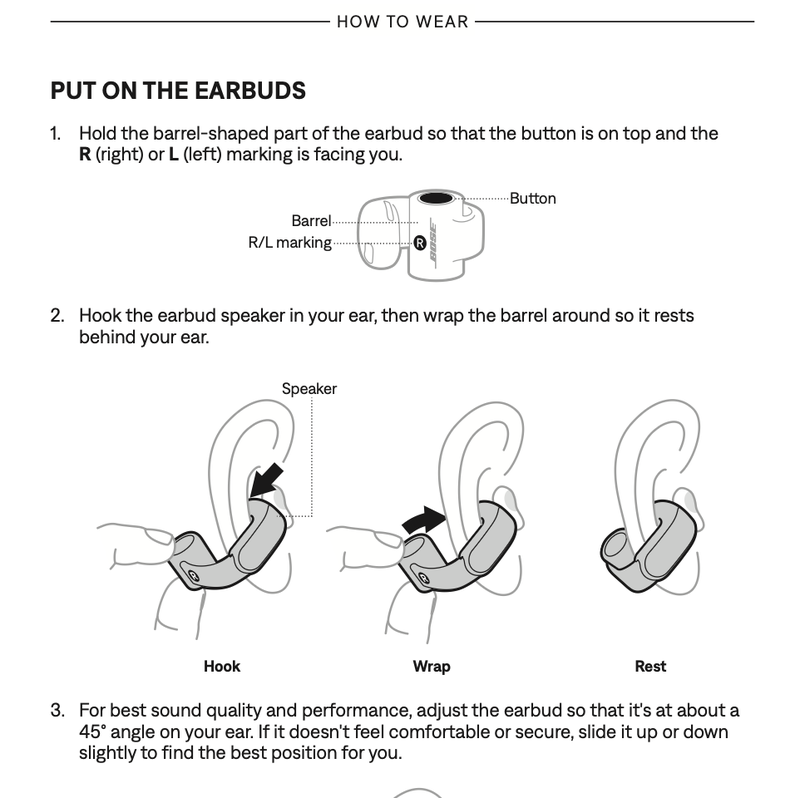

## Elasticsearch Source Connector

Next, we'll connect to your Elasticsearch index containing structured sales data, completing our dual-source setup.

### Sales Records Data Structure

The image below shows the structure of the consolidated sales records in your Elasticsearch index. This data represents customer transactions and will be processed alongside the product manuals to create a unified knowledge base.

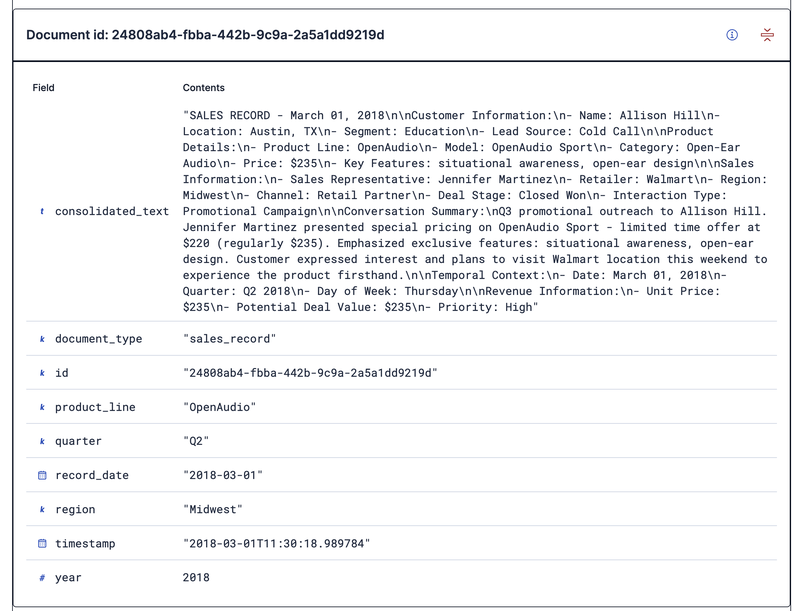

## Elasticsearch Destination Connector

Finally, we'll create the destination where both data streams will converge: the unified `customer-support` index where all processed data will be stored.

In [ ]:
def create_s3_source_connector():
    """Create an S3 source connector for PDF documents."""
    try:
        if not S3_SOURCE_BUCKET:
            raise ValueError("S3_SOURCE_BUCKET is required (bucket name, s3:// URL, or https:// URL)")
        value = S3_SOURCE_BUCKET.strip()

        if value.startswith("s3://"):
            s3_style = value if value.endswith("/") else value + "/"
        elif value.startswith("http://") or value.startswith("https://"):
            parsed = urlparse(value)
            host = parsed.netloc
            path = parsed.path or "/"
            bucket = host.split(".s3.")[0]
            s3_style = f"s3://{bucket}{path if path.endswith('/') else path + '/'}"
        else:
            s3_style = f"s3://{value if value.endswith('/') else value + '/'}"
        
        with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
            response = client.sources.create_source(
                request=CreateSourceRequest(
                    create_source_connector=CreateSourceConnector(
                        name="<name>",
                        type="s3",
                        config={
                            "remote_url": s3_style,
                            "recursive": True, 
                            "key": AWS_ACCESS_KEY_ID,
                            "secret": AWS_SECRET_ACCESS_KEY,
                        }
                    )
                )
            )
        
        source_id = response.source_connector_information.id
        print(f"✅ Created S3 PDF source connector: {source_id} -> {s3_style}")
        return source_id
        
    except Exception as e:
        print(f"❌ Error creating S3 source connector: {e}")
        return None

def create_elasticsearch_source_connector():
    """Create an Elasticsearch source connector for sales data."""
    try:
        with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
            response = client.sources.create_source(
                request=CreateSourceRequest(
                    create_source_connector=CreateSourceConnector(
                        name=f"elasticsearch_sales_source_{int(time.time())}",
                        type="elasticsearch",
                        config={
                            "hosts": [ELASTICSEARCH_HOST],
                            "es_api_key": ELASTICSEARCH_API_KEY,
                            "index_name": ELASTICSEARCH_INDEX
                        }
                    )
                )
            )
        
        source_id = response.source_connector_information.id
        print(f"✅ Created Elasticsearch sales source connector: {source_id}")
        return source_id
    
    except Exception as e:
        print(f"❌ Error creating Elasticsearch source connector: {e}")
        return None

def create_elasticsearch_destination_connector():
    """Create an Elasticsearch destination connector for processed results."""
    try:
        with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
            response = client.destinations.create_destination(
                request=CreateDestinationRequest(
                    create_destination_connector=CreateDestinationConnector(
                        name=f"elasticsearch_customer_support_destination_{int(time.time())}",
                        type="elasticsearch",
                        config={
                            "hosts": [ELASTICSEARCH_HOST],
                            "es_api_key": ELASTICSEARCH_API_KEY,
                            "index_name": "customer-support"
                        }
                    )
                )
            )

        destination_id = response.destination_connector_information.id
        print(f"✅ Created Elasticsearch destination connector: {destination_id}")
        return destination_id
        
    except Exception as e:
        print(f"❌ Error creating Elasticsearch destination connector: {e}")
        return None

## Processing Pipeline Configuration

With our connectors in place, we can now configure the intelligent processing pipeline that will transform both data sources. This four-stage pipeline (VLM → Chunker → Embedder → NER) will be applied to both workflows, ensuring consistent processing regardless of data source.

In [ ]:
def create_workflow_nodes():
    """Create shared processing nodes for workflows."""
    vlm_partition_node = WorkflowNode(
        name="VLM_Partitioner",
        subtype="vlm",
        type="partition",
        settings={
            "provider": "openai",
            "model": "gpt-4o",
        }
    )
    
    chunk_node = WorkflowNode(
        name="Chunker_Node",
        subtype="chunk_by_title",
        type="chunk",
        settings={
            "new_after_n_chars": 1500,
            "max_characters": 2048,
            "overlap": 0
        }
    )
    
    embedder_node = WorkflowNode(
        name="Embedder_Node",
        subtype="openai",
        type="embed",
        settings={
            "model_name": "text-embedding-3-small"
        }
    )
    
    ner_enrichment_node = WorkflowNode(
        name="NER_Enrichment",
        type="prompter",
        subtype="openai_ner",
        settings={}
    )
    
    return vlm_partition_node, chunk_node, embedder_node, ner_enrichment_node

def create_parallel_workflows(s3_source_id, elasticsearch_source_id, destination_id):
    """Create separate workflows for S3 PDFs and Elasticsearch data that run in parallel."""
    try:
        vlm_partition_node, chunk_node, embedder_node, ner_enrichment_node = create_workflow_nodes()
        
        # Create workflow for S3 PDFs
        s3_workflow_id = None
        if s3_source_id:
            with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
                s3_workflow = CreateWorkflow(
                    name=f"S3-PDFs-Parallel-Workflow_{int(time.time())}",
                    source_id=s3_source_id,
                    destination_id=destination_id,
                    workflow_type=WorkflowType.CUSTOM,
                    workflow_nodes=[
                        vlm_partition_node,
                        chunk_node,
                        embedder_node,
                        ner_enrichment_node
                    ]
                )
                
                s3_response = client.workflows.create_workflow(
                    request=CreateWorkflowRequest(
                        create_workflow=s3_workflow
                    )
                )
            
            s3_workflow_id = s3_response.workflow_information.id
            print(f"✅ Created S3 PDF workflow: {s3_workflow_id}")
        
        # Create workflow for Elasticsearch sales data
        with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
            es_workflow = CreateWorkflow(
                name=f"Elasticsearch-Sales-Parallel-Workflow_{int(time.time())}",
                source_id=elasticsearch_source_id,
                destination_id=destination_id,
                workflow_type=WorkflowType.CUSTOM,
                workflow_nodes=[
                    vlm_partition_node,
                    chunk_node,
                    embedder_node,
                    ner_enrichment_node
                ]
            )
            
            es_response = client.workflows.create_workflow(
                request=CreateWorkflowRequest(
                    create_workflow=es_workflow
                )
            )
        
        es_workflow_id = es_response.workflow_information.id
        print(f"✅ Created Elasticsearch sales workflow: {es_workflow_id}")
        
        return s3_workflow_id, es_workflow_id
        
    except Exception as e:
        print(f"❌ Error creating parallel workflows: {e}")
        return None, None

## Creating Parallel Processing Workflows

Now we'll assemble everything into the two parallel workflows shown in our architecture diagram above, connecting each data source to the processing pipeline and unified destination.

## Starting Your Processing Jobs

With our workflows configured, it's time to put them into action. This step submits both workflows to the Unstructured API and returns job IDs for monitoring.

In [ ]:
def run_workflow(workflow_id, workflow_name):
    """Run a workflow and return job information."""
    try:
        with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
            response = client.workflows.run_workflow(
                request={"workflow_id": workflow_id}
            )
        
        job_id = response.job_information.id
        print(f"✅ Started {workflow_name} job: {job_id}")
        return job_id
        
    except Exception as e:
        print(f"❌ Error running {workflow_name} workflow: {e}")
        return None

def poll_job_status(job_id, job_name, wait_time=30):
    """Poll job status until completion."""
    print(f"⏳ Monitoring {job_name} job status...")
    
    while True:
        try:
            with UnstructuredClient(api_key_auth=UNSTRUCTURED_API_KEY) as client:
                response = client.jobs.get_job(
                    request={"job_id": job_id}
                )
            
            job = response.job_information
            status = job.status
            
            if status in ["SCHEDULED", "IN_PROGRESS"]:
                print(f"⏳ {job_name} job status: {status}")
                time.sleep(wait_time)
            elif status == "COMPLETED":
                print(f"✅ {job_name} job completed successfully!")
                return job
            elif status == "FAILED":
                print(f"❌ {job_name} job failed!")
                return job
            else:
                print(f"❓ Unknown {job_name} job status: {status}")
                return job
                
        except Exception as e:
            print(f"❌ Error polling {job_name} job status: {e}")
            time.sleep(wait_time)

## Monitoring Your Processing Progress

Jobs progress through scheduled, in-progress, completed, or failed states. The `poll_job_status` function checks status every 30 seconds and blocks execution until jobs complete, so you can see exactly what's happening with your data processing.

## Preparing Your Elasticsearch Environment

Before processing begins, we validate that the `sales-records-consolidated` index exists and contains data, then recreate the `customer-support` index fresh for each run. This preparation step ensures a clean environment and prevents any issues from previous runs.

### Index Mapping

The destination index uses this structure optimized for RAG applications:
```json
{
  "id": "keyword",           // Unique document identifier
  "timestamp": "date",       // Processing timestamp
  "text": "text",           // Searchable content
  "metadata": "object"      // Source info and entities
}
```

In [ ]:
def run_elasticsearch_preprocessing():
    """Check and manage Elasticsearch indices for the pipeline."""
    print("🔧 Running Elasticsearch preprocessing...")
    
    try:
        es = Elasticsearch(
            ELASTICSEARCH_HOST,
            api_key=ELASTICSEARCH_API_KEY,
            request_timeout=60,
            max_retries=3,
            retry_on_timeout=True
        )
        
        sales_index = "sales-records-consolidated"
        print(f"�� Checking {sales_index} index...")
        
        if not es.indices.exists(index=sales_index):
            raise ValueError(f"❌ Index '{sales_index}' does not exist. There is no data to use.")
        
        count_response = es.count(index=sales_index)
        doc_count = count_response['count']
        
        if doc_count == 0:
            raise ValueError(f"❌ Index '{sales_index}' is empty. There is no data to use.")
        
        print(f"✅ Found {doc_count} records in {sales_index}")
        
        # Handle customer-support index
        support_index = "customer-support"
        print(f"🔍 Checking {support_index} index...")
        
        if es.indices.exists(index=support_index):
            print(f"🗑️ Deleting existing {support_index} index...")
            es.indices.delete(index=support_index)
        
        # Create fresh customer-support index
        print(f"🔧 Creating fresh {support_index} index...")
        mapping = {
            "settings": {
                "number_of_shards": 1,
                "number_of_replicas": 1
            },
            "mappings": {
                "properties": {
                    "id": {"type": "keyword"},
                    "timestamp": {"type": "date"},
                    "text": {"type": "text", "analyzer": "standard"},
                    "metadata": {"type": "object"}
                }
            }
        }
        
        es.indices.create(index=support_index, body=mapping)
        es.indices.refresh(index=support_index)
        
        print(f"✅ Successfully created fresh {support_index} index")
        print("✅ Elasticsearch preprocessing completed successfully")
        return True
        
    except ValueError as e:
        print(str(e))
        return False
    except Exception as e:
        print(f"❌ Error during Elasticsearch preprocessing: {e}")
        return False

## Pipeline Execution Summary

The following summary displays all resources created during pipeline setup: data source paths, connector IDs, workflow IDs, job IDs, and processing status.

In [ ]:
import os

def print_pipeline_summary(s3_workflow_id, es_workflow_id, s3_job_id, es_job_id):
    """Print comprehensive pipeline summary."""
    print("\n" + "=" * 80)
    print("📊 HYBRID RAG PIPELINE SUMMARY")
    print("=" * 80)
    print(f"📁 S3 Source (PDFs): {S3_SOURCE_BUCKET if s3_workflow_id else SKIPPED}")
    print(f"🔍 Elasticsearch Source: {ELASTICSEARCH_HOST}/{ELASTICSEARCH_INDEX}")
    print(f"📤 Elasticsearch Destination: {ELASTICSEARCH_HOST}/customer-support")
    print(f"")
    print(f"⚙️ S3 PDFs Workflow ID: {s3_workflow_id if s3_workflow_id else SKIPPED}")
    print(f"⚙️ Elasticsearch Sales Workflow ID: {es_workflow_id}")
    print(f"")
    print(f"🚀 S3 PDFs Job ID: {s3_job_id if s3_job_id else SKIPPED}")
    print(f"🚀 Elasticsearch Sales Job ID: {es_job_id}")

def verify_customer_support_results(s3_job_id=None, es_job_id=None):
    """
    Verifies the processed results in the customer-support index, prettyprinting one doc per unique source connector.
    Assumes jobs have already completed successfully.
    """
    import pprint

    print("🔍 Verifying processed results in 'customer-support' index (assuming jobs have completed)...")

    try:
        # Initialize Elasticsearch client
        es = Elasticsearch(
            ELASTICSEARCH_HOST,
            api_key=ELASTICSEARCH_API_KEY,
            request_timeout=60,
            max_retries=3,
            retry_on_timeout=True
        )

        index_name = "customer-support"

        # Check if index exists
        if not es.indices.exists(index=index_name):
            print(f"❌ Index '{index_name}' does not exist. Workflows may not have written results yet.")
            return

        # Get document count
        count_response = es.count(index=index_name)
        total_docs = count_response['count']
        print(f"📊 Total processed documents: {total_docs}")

        if total_docs == 0:
            print("⏳ No documents found yet. Workflows may still be processing or index is empty.")
            print("💡 Check the Unstructured dashboard for job status.")
            return

        print(f"\n📋 Analyzing Source Connectors:")
        print("=" * 40)

        # Get sample documents to analyze source patterns
        # Use function_score with random_score to sample documents randomly
        sample_response = es.search(
            index=index_name,
            body={
                "size": 50,  # Get more samples to increase chance of seeing all sources
                "_source": ["metadata", "text", "element_id"],
                "query": {
                    "function_score": {
                        "query": {"match_all": {}},
                        "random_score": {}
                    }
                }
            }
        )
        

        # Map: source_connector_key -> [doc, ...]
        source_connector_map = {}
        unknown_docs = []

        for hit in sample_response['hits']['hits']:
            source = hit['_source']
            metadata = source.get('metadata', {})
            
            # Determine source connector type based on metadata patterns
            if "data_source-record_locator-index_name" in metadata:
                # Elasticsearch source connector
                key = f"elasticsearch:{metadata['data_source-record_locator-index_name']}"
            elif "data_source-url" in metadata:
                # S3 source connector - group all S3 URLs by bucket
                url = metadata['data_source-url']
                if url.startswith('s3://'):
                    # Extract bucket name from S3 URL
                    bucket = url.split('/')[2] if '/' in url else url.replace('s3://', '')
                    key = f"s3:{bucket}"
                else:
                    key = f"s3:unknown"
            elif "filename" in metadata and metadata.get('filetype') == 'pdf':
                # PDF files from S3 (fallback detection)
                key = "s3:pdfs"
            else:
                key = "unknown"

            if key == "unknown":
                unknown_docs.append(hit)
            else:
                if key not in source_connector_map:
                    source_connector_map[key] = hit  # Only keep the first doc for each source connector

        print(f"🔍 Unique source connectors found: {len(source_connector_map)}")
        for i, (key, doc) in enumerate(source_connector_map.items(), 1):
            print(f"\n--- Source Connector {i} ({key}) ---")
            pprint.pprint(doc['_source'], depth=6, compact=False, sort_dicts=False)

        if unknown_docs:
            print(f"\n❓ Example Unknown Source Document:")
            print("-" * 35)
            unknown_example = unknown_docs[0]['_source']
            metadata = unknown_example.get('metadata', {})
            text = unknown_example.get('text', '')
            print(f"   Element ID: {unknown_example.get('element_id', 'N/A')}")
            print(f"   Metadata: {metadata}")
            print(f"   Text Preview: {text[:200]}..." if len(text) > 200 else f"   Text: {text}")
            print("   Metadata prettyprint:")
            pprint.pprint(metadata, depth=6, compact=False, sort_dicts=False)

        # Test search functionality
        print(f"\n🔍 Testing Search Functionality:")
        print("=" * 32)

        search_tests = ["manual", "customer", "product", "support"]

        for search_term in search_tests:
            search_response = es.search(
                index=index_name,
                body={
                    "size": 1,
                    "query": {
                        "match": {
                            "text": search_term
                        }
                    }
                }
            )

            hits = search_response['hits']['total']['value']
            print(f"   🔎 '{search_term}': {hits} matches")

        print(f"\n" + "=" * 50)
        print("🎉 CUSTOMER-SUPPORT INDEX VERIFICATION")
        print("=" * 50)
        print("✅ Index exists and contains processed documents")
        print("✅ Documents from both source connectors are present (if both completed)")
        print("✅ Text search is functional across processed content")
        print("✅ Ready for hybrid RAG queries!")

    except Exception as e:
        print(f"❌ Error verifying results: {e}")
        print("💡 This is normal if workflows are still processing or if there is a connection issue.")

## Orchestrating Your Complete Pipeline

The main function coordinates all pipeline steps in logical sequence: data preparation, environment validation, connector setup, workflow creation, execution, and summary reporting.

In [ ]:
def main():
    """Main pipeline execution"""
    print("🚀 Starting Hybrid RAG Pipeline")
    
    print("\n📦 Step 0: Data source preparation")
    print("-" * 50)
    
    if not prepare_data_sources():
        print("❌ Failed to prepare data sources")
        return
    
    print("\n🔧 Step 1: Elasticsearch preprocessing")
    print("-" * 50)
    
    if not run_elasticsearch_preprocessing():
        print("❌ Failed to complete Elasticsearch preprocessing")
        return
    
    print("\n🔗 Step 2: Creating source connectors")
    print("-" * 50)
    
    s3_source_id = create_s3_source_connector()
    if not s3_source_id:
        print("❌ Failed to create S3 source connector")
        return
    
    elasticsearch_source_id = create_elasticsearch_source_connector()
    if not elasticsearch_source_id:
        print("❌ Failed to create Elasticsearch source connector")
        return
    
    # Step 3: Create Destination Connector
    print("\n🎯 Step 3: Creating Elasticsearch destination connector")
    print("-" * 50)
    
    destination_id = create_elasticsearch_destination_connector()
    if not destination_id:
        print("❌ Failed to create destination connector")
        return
    
    # Step 4: Create Workflows
    print("\n⚙️ Step 4: Creating workflows")
    print("-" * 50)
    
    s3_workflow_id, es_workflow_id = create_parallel_workflows(
        s3_source_id, elasticsearch_source_id, destination_id
    )
    
    if not es_workflow_id:
        print("❌ Failed to create Elasticsearch workflow")
        return
    
    # Step 5: Run Workflows
    print("\n🚀 Step 5: Running workflows")
    print("-" * 50)
    
    s3_job_id = None
    es_job_id = None

    if s3_workflow_id:
        s3_job_id = run_workflow(s3_workflow_id, "S3 PDFs")
        if not s3_job_id:
            print("❌ Failed to start S3 workflow")
            return

    if es_workflow_id:
        es_job_id = run_workflow(es_workflow_id, "Elasticsearch Sales")
        if not es_job_id:
            print("❌ Failed to start Elasticsearch workflow")
            return

    # Step 6: Pipeline Summary
    print_pipeline_summary(s3_workflow_id, es_workflow_id, s3_job_id, es_job_id)
    return s3_job_id, es_job_id 

## Running Your Complete Pipeline

We'll execute the complete pipeline by calling the main function to create all resources and start processing, then monitor the jobs until they complete successfully.

In [ ]:
s3_job_id, es_job_id = main()

es_job_info = poll_job_status(es_job_id, "Elasticsearch Ingest")
s3_job_info = poll_job_status(s3_job_id, "S3 Ingest")
print("\n🔍 Verifying processed results")
print("-" * 50)
verify_customer_support_results()

### Unified Knowledge Base Results

After processing both data sources, the pipeline creates a unified `customer-support` index containing processed documents from both S3 PDFs and Elasticsearch sales records. The image below shows the structure of this consolidated knowledge base, ready for RAG queries.

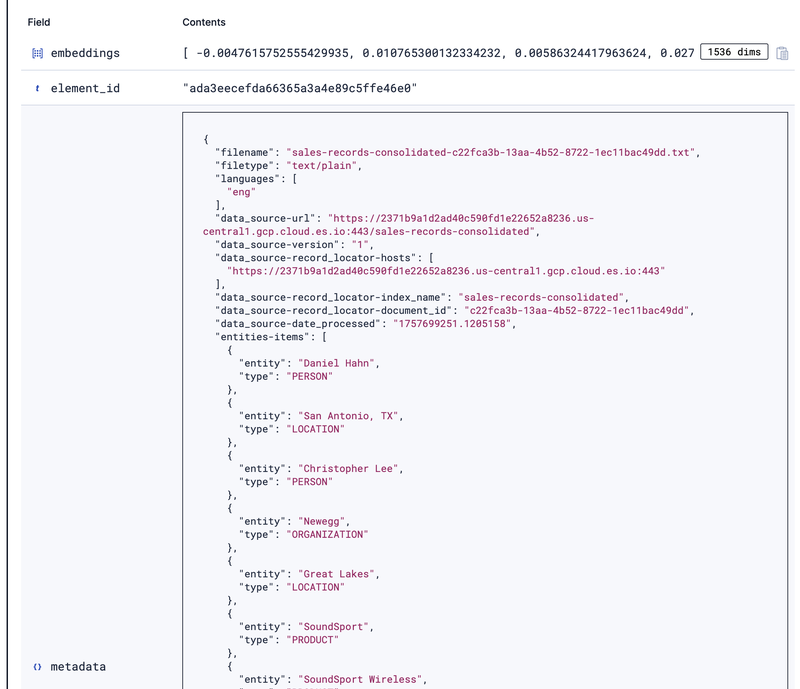

## RAG Query Demonstration

Now that your hybrid knowledge base is ready, we'll demonstrate how to query it using RAG (Retrieval-Augmented Generation). This is where you'll see how the system can answer complex questions by pulling relevant information from both your S3 documents and Elasticsearch records.

### OpenAI API Key Required

For the RAG demonstration, you'll need an OpenAI API key to power the language model that generates answers based on your retrieved documents. Visit https://platform.openai.com/api-keys to sign in or create an account and generate a new API key.

The demonstration will show cross-source querying, source attribution, and semantic understanding as your hybrid RAG system answers questions by combining information from multiple data sources.

### RAG Configuration

**Instructions**: Paste your OpenAI API key below to enable RAG demonstrations. This key will be used to power the language model that generates answers based on your retrieved documents.

In [ ]:
# RAG Demonstration Configuration and Queries

RAG_OPENAI_API_KEY = "your-openai-api-key-here"

RAG_OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", RAG_OPENAI_API_KEY)

print("🤖 RAG Query Demonstration Setup")
print("=" * 40)

if not RAG_OPENAI_API_KEY or RAG_OPENAI_API_KEY.startswith("your-"):
    print("⚠️ OpenAI API key not configured.")
    print("💡 Please update the RAG_OPENAI_API_KEY variable above with your actual OpenAI API key.")
    print("📝 You can get one at: https://platform.openai.com/api-keys")
else:
    print("✅ OpenAI API key configured for RAG demonstrations")

def setup_rag_system():
    """Initialize the RAG system with LangChain and Elasticsearch."""
    if not RAG_OPENAI_API_KEY or RAG_OPENAI_API_KEY.startswith("your-"):
        print("❌ Cannot setup RAG system without OpenAI API key")
        return None
    
    try:
        from langchain_elasticsearch import ElasticsearchStore
        from langchain_openai import OpenAIEmbeddings, ChatOpenAI
        from langchain_core.prompts import ChatPromptTemplate
        from langchain_core.output_parsers import StrOutputParser
        from langchain_core.runnables import RunnablePassthrough
        
        # Set OpenAI API key
        os.environ["OPENAI_API_KEY"] = RAG_OPENAI_API_KEY
        
        print("🔧 Setting up RAG components...")
        
        # Initialize embeddings (same model used in processing)
        embeddings = OpenAIEmbeddings(
            model="text-embedding-3-small",
            openai_api_key=RAG_OPENAI_API_KEY
        )
        
        # Connect to Elasticsearch vector store - using your working pattern
        vector_store = ElasticsearchStore(
            index_name="customer-support",
            embedding=embeddings,
            es_url=ELASTICSEARCH_HOST,
            es_api_key=ELASTICSEARCH_API_KEY,
            vector_query_field="embeddings",
            query_field="text",
        )
        
        # Create retriever
        retriever = vector_store.as_retriever(search_kwargs={"k": 5})
        
        # Initialize LLM
        llm = ChatOpenAI(
            model="gpt-3.5-turbo",
            temperature=0,
            openai_api_key=RAG_OPENAI_API_KEY
        )
        
        # Enhanced prompt template that leverages NER metadata
        prompt = ChatPromptTemplate.from_template("""
Use the following context to answer the question. Pay attention to any entity information (people, organizations, products, locations, dates) and relationships mentioned in the context.

Context:
{context}

Question:
{question}
""")
        
        print("✅ RAG system ready!")
        return {"retriever": retriever, "llm": llm, "prompt": prompt}
        
    except ImportError as e:
        print(f"❌ Missing RAG dependencies: {e}")
        print("💡 Install with: pip install langchain langchain-elasticsearch langchain-openai")
        return None
    except Exception as e:
        print(f"❌ Error setting up RAG system: {e}")
        return None

def extract_ner_entities(docs):
    """Extract NER entities from document metadata."""
    entities = {"people": set(), "organizations": set(), "products": set(), "locations": set(), "dates": set()}
    
    for doc in docs:
        metadata = doc.metadata
        if "entities-items" in metadata:
            try:
                import json
                entity_items = json.loads(metadata["entities-items"]) if isinstance(metadata["entities-items"], str) else metadata["entities-items"]
                
                for item in entity_items:
                    entity_type = item.get("type", "").upper()
                    entity_name = item.get("entity", "")
                    
                    if entity_type == "PERSON":
                        entities["people"].add(entity_name)
                    elif entity_type == "ORGANIZATION":
                        entities["organizations"].add(entity_name)
                    elif entity_type == "PRODUCT":
                        entities["products"].add(entity_name)
                    elif entity_type == "LOCATION":
                        entities["locations"].add(entity_name)
                    elif entity_type == "DATE":
                        entities["dates"].add(entity_name)
            except:
                pass
    
    return entities

def analyze_sources(docs):
    """Analyze retrieved documents by source type."""
    s3_docs = []
    es_docs = []
    unknown_docs = []
    
    for doc in docs:
        metadata = doc.metadata
        if "data_source-record_locator-index_name" in metadata:
            es_docs.append(doc)
        elif "data_source-url" in metadata and "s3://" in metadata.get("data_source-url", ""):
            s3_docs.append(doc)
        else:
            unknown_docs.append(doc)
    
    return s3_docs, es_docs, unknown_docs

def demonstrate_hybrid_ner_queries(rag_components):
    """Demonstrate NER-enhanced hybrid RAG capabilities."""
    if not rag_components:
        return
    
    retriever = rag_components["retriever"]
    llm = rag_components["llm"]
    prompt = rag_components["prompt"]
    
    # Build RAG chain using your working pattern
    rag_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    
    # Hybrid NER demonstration queries targeting different sources
    hybrid_queries = [
        {
            "query": "How do I troubleshoot Bose headphone connectivity issues?",
            "description": "Product support query targeting S3 PDFs (product manuals)",
            "expected_source": "S3 (Product Docs)"
        },
        {
            "query": "Tell me about Daniel Hahn and his purchases",
            "description": "Customer analysis query targeting Elasticsearch (sales data)",
            "expected_source": "Elasticsearch (Sales)"
        },
        {
            "query": "What are the technical specifications for SoundSport Wireless headphones?",
            "description": "Product specification query targeting S3 PDFs",
            "expected_source": "S3 (Product Docs)"
        },
        {
            "query": "Show me customers in San Antonio, TX",
            "description": "Geographic customer query targeting Elasticsearch",
            "expected_source": "Elasticsearch (Sales)"
        },
        {
            "query": "How do I reset wireless headphones to factory settings?",
            "description": "Technical support query targeting S3 PDFs",
            "expected_source": "S3 (Product Docs)"
        },
        {
            "query": "What products does Newegg sell and what are their features?",
            "description": "Hybrid query targeting BOTH sources (sales + product specs)",
            "expected_source": "Both S3 and Elasticsearch"
        },
        {
            "query": "I have a customer who bought Bose headphones and is having connectivity issues. What should I tell them?",
            "description": "Customer support query requiring BOTH customer data AND product manuals",
            "expected_source": "Both S3 and Elasticsearch"
        }
    ]
    
    print("\n🧠 Hybrid NER-Enhanced RAG Demonstration")
    print("=" * 60)
    
    for i, query_info in enumerate(hybrid_queries, 1):
        query = query_info["query"]
        description = query_info["description"]
        expected_source = query_info["expected_source"]
        
        print(f"\n{'='*70}")
        print(f"Query {i}: {description}")
        print(f"📝 Query: {query}")
        print(f"🎯 Expected Source: {expected_source}")
        print("=" * 70)
        
        try:
            # Retrieve documents
            docs = retriever.invoke(query)
            
            if not docs:
                print("❌ No documents retrieved")
                continue
            
            # Analyze sources (keeping your preferred format)
            s3_docs, es_docs, unknown_docs = analyze_sources(docs)
            print(f"📊 Retrieved {len(docs)} documents:")
            print(f"   📄 S3 (Product Docs): {len(s3_docs)}")
            print(f"   📊 Elasticsearch (Sales): {len(es_docs)}")
            print(f"   ❓ Unknown: {len(unknown_docs)}")
            
            # Check if we hit the expected source
            if expected_source == "S3 (Product Docs)" and len(s3_docs) > 0:
                print("✅ SUCCESS: Retrieved from expected S3 source!")
            elif expected_source == "Elasticsearch (Sales)" and len(es_docs) > 0:
                print("✅ SUCCESS: Retrieved from expected Elasticsearch source!")
            elif expected_source == "Both S3 and Elasticsearch" and len(s3_docs) > 0 and len(es_docs) > 0:
                print("✅ SUCCESS: Retrieved from BOTH sources as expected!")
            elif expected_source.startswith("Both") and (len(s3_docs) > 0 or len(es_docs) > 0):
                print("✅ PARTIAL: Retrieved from at least one expected source")
            else:
                print("⚠️ UNEXPECTED: Did not retrieve from expected source")
            
            # Extract and show NER entities
            entities = extract_ner_entities(docs)
            print(f"\n🏷️ NER Entities Found:")
            if entities["people"]:
                print(f"   👤 People: {', '.join(list(entities['people'])[:3])}")
            if entities["organizations"]:
                print(f"   🏢 Organizations: {', '.join(list(entities['organizations'])[:3])}")
            if entities["products"]:
                print(f"   📱 Products: {', '.join(list(entities['products'])[:3])}")
            if entities["locations"]:
                print(f"   🗺️ Locations: {', '.join(list(entities['locations'])[:3])}")
            if entities["dates"]:
                print(f"   📅 Dates: {', '.join(list(entities['dates'])[:3])}")
            
            # Generate answer
            print(f"\n💬 Answer:")
            answer = rag_chain.invoke(query)
            print(f"{answer}")
                
        except Exception as e:
            print(f"❌ Error: {e}")
            if "429" in str(e):
                print("⚠️ OpenAI API quota exceeded. Stopping demo.")
                break
    
    print(f"\n{'='*70}")
    print("🧠 Hybrid NER Demo Complete!")
    print("✅ Demonstrated cross-source retrieval capabilities")
    print("✅ Showed NER metadata integration across data sources")
    print("✅ Validated hybrid RAG architecture")

def run_rag_demonstration():
    """Run the RAG demonstration."""
    print("\n🚀 Starting Hybrid RAG Demonstration")
    print("=" * 50)
    
    rag_components = setup_rag_system()
    
    if rag_components:
        demonstrate_hybrid_ner_queries(rag_components)
    else:
        print("❌ RAG demonstration skipped due to configuration issues")

# Run the demonstration
run_rag_demonstration()

## What You've Accomplished

**Enterprise Data Integration**: You've learned how to process multiple data formats (PDFs, structured records) in parallel, why consistent processing pipelines matter for unified search, and the value of creating a single searchable knowledge base that spans all your data sources.

**Unstructured API Capabilities**: You've experienced VLM-powered document partitioning for complex layouts, intelligent chunking that preserves document structure, named entity recognition for enhanced search precision, and unified processing across diverse data sources.

**RAG System Architecture**: You've built parallel workflow design for scalability and reliability, vector embeddings for semantic similarity search, source attribution in mixed-data query results, and NER-enhanced query understanding and response generation.

### Ready to Scale?

Deploy customer support chatbots with comprehensive knowledge access, build internal search tools that surface information from any source, or create automated content recommendation systems. Add more data sources using additional workflows, implement real-time data synchronization, or scale up for production data volumes with monitoring and alerting.

### Try Unstructured Today

Ready to build your own hybrid RAG system? [Sign up for a free trial](https://unstructured.io/?modal=try-for-free) and start transforming your enterprise data into intelligent, searchable knowledge.

**Need help getting started?** Contact our team to schedule a demo and see how Unstructured can solve your specific data challenges.